In [27]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json
from collections import defaultdict
import os

In [2]:
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Load the ScWs.

In [3]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(",")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

In [4]:
crab = SkyCoord.from_name("Crab")
crab_ra = crab.ra.deg
crab_dec = crab.dec.deg

crab_coords = coord.SkyCoord(ra=crab_ra, dec=crab_dec, unit=(u.deg, u.deg))

## QUERYING 

As we can see, Crab observations only happen twice per year in 3-month groups (Feb->Apr and Aug->Oct).
The idea now will be to get some longterm lightcurves over the years and see how the countrate evolves. Depending on the variability of the countrate, we will use it for flux conversion.

## IMAGES

We use asynchronous querying. We aim to get one result per month, every year. Since the ScWs only happen in two 3-month intervals per year, this will mean 6 results every year for 22 years so 120 results total. 

To choose the ScW every month, we will take the shortest one for time reasons.

In [5]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

How many ScWs when filtering pointings and choosing only one per month?

In [6]:
scw_per_month = {}
scw_count_by_year_month = {}
filtered_scw_per_month = {}

for scw_id, ym in zip(scw, year_months):
    if ym not in scw_per_month:
        scw_per_month[ym] = scw_id  

print(f"Number of SCWs if picking one per month: {len(scw_per_month)}")

for year_month in sorted(set(year_months)):
    filtered_scws = [
        (scw[i], isot_start_times[i], isot_end_times[i])
        for i, year_month_in_list in enumerate(year_months)
        if year_month_in_list == year_month
    ]

    if not filtered_scws:
        scw_count_by_year_month[year_month] = 0
        continue

    rrrr_max_pppp = defaultdict(int)
    for scwgr in filtered_scws:
        rrrr = scwgr[0][:4]  
        pppp = int(scwgr[0][4:8])
        rrrr_max_pppp[rrrr] = max(rrrr_max_pppp[rrrr], pppp)

    filtered_scws = [
        scwind for scwind in filtered_scws
        if 5 < int(scwind[0][4:8]) < rrrr_max_pppp[scwind[0][:4]] - 10
    ]

    scw_count_by_year_month[year_month] = len(filtered_scws)

    # Check if the "one-per-month" SCW is in the filtered list
    if year_month in scw_per_month and scw_per_month[year_month] in [scwind[0] for scwind in filtered_scws]:
        filtered_scw_per_month[year_month] = scw_per_month[year_month]

print(f"Total SCWs after filtering: {sum(scw_count_by_year_month.values())}")
print(f"Total SCWs when picking one per month AND applying filtering: {len(filtered_scw_per_month)}")

Number of SCWs if picking one per month: 104
Total SCWs after filtering: 4931
Total SCWs when picking one per month AND applying filtering: 43


In [ ]:
'''disp_by_date = {} 
data_by_date = {}
successful_scws = []

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

while True:
    image_results = []

    for year_month in sorted(set(year_months)):
        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        # add filtering for not choosing the first 5 and last 10 ScWs of each revolution 
        # (ScWs look like RRRRPPPPSSS.001, so choose 5 < PPPP < max(PPPP) - 10)
        rrrr_max_pppp = defaultdict(int)
        for scwgr in filtered_scws:
            rrrr = scwgr[0][:4]  
            pppp = int(scwgr[0][4:8])
            rrrr_max_pppp[rrrr] = max(rrrr_max_pppp[rrrr], pppp)

        filtered_scws = [
            scwind for scwind in filtered_scws
            if 5 < int(scwind[0][4:8]) < rrrr_max_pppp[scwind[0][:4]] - 10
        ]

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering for pointings")
            continue
        else:
            print(f"{len(filtered_scws)} SCWs found for {year_month} after filtering for pointings")

        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration} for {year_month}")

            par_dict = {
                "RA": crab_ra,
                "DEC": crab_dec,
                "E1_keV": "15",
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "detection_threshold": "5",
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_image",
                "product_type": "Real",
                "scw_list": [scw_id],
                #'token': disp.disable_email_token(oda_api.token.discover_token()),
            }

            if scw_id not in disp_by_date:
                disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = disp_by_date[scw_id]

            data = data_by_date.get(scw_id, None)

            if data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        data = _disp.get_product(**par_dict, silent=True)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        # continue  # Retry with the next SCW
                        # raise ValueError("Query incomplete")
                        break

                    data = _disp.get_product(**par_dict, silent=True)
                    data_by_date[scw_id] = data
                    image_results.append(data)
                    successful_scws.append(scw_id)
                    print(f"Query successful for SCW {scw_id}")
                    break  # Stop trying other SCWs for this month

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        else:
            print(f"All SCWs failed for {year_month}, skipping.")
            # print(f"Skipping {year_month} due to errors.")

    n_complete = len([year for year, _disp in disp_by_date.items() if _disp.is_complete])
    print(f"complete {n_complete} / {len(disp_by_date)}")

    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")'''

In [7]:
disp_by_date = {} 
data_by_date = {}
successful_scws = []

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

# Keep track of the year-months that have already been processed
processed_year_months = set()

while True:
    image_results = []

    for year_month in sorted(set(year_months)):
        if year_month in processed_year_months:
            print(f"Already processed {year_month}, skipping.")
            continue  # Skip if this year-month has already been processed

        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        # Add filtering for not choosing the first 5 and last 10 SCWs of each revolution
        rrrr_max_pppp = defaultdict(int)
        for scwgr in filtered_scws:
            rrrr = scwgr[0][:4]  
            pppp = int(scwgr[0][4:8])
            rrrr_max_pppp[rrrr] = max(rrrr_max_pppp[rrrr], pppp)

        filtered_scws = [
            scwind for scwind in filtered_scws
            if 5 < int(scwind[0][4:8]) < rrrr_max_pppp[scwind[0][:4]] - 10
        ]

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering for pointings")
            continue
        else:
            print(f"{len(filtered_scws)} SCWs found for {year_month} after filtering for pointings")

        # Process SCWs for the current year-month
        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration} for {year_month}")

            par_dict = {
                "RA": crab_ra,
                "DEC": crab_dec,
                "E1_keV": "15",
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "detection_threshold": "5",
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_image",
                "product_type": "Real",
                "scw_list": [scw_id],
            }

            if scw_id not in disp_by_date:
                disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = disp_by_date[scw_id]

            data = data_by_date.get(scw_id, None)

            if data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        data = _disp.get_product(**par_dict, silent=True)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        break  # Continue to the next SCW if not complete

                    data = _disp.get_product(**par_dict, silent=True)
                    data_by_date[scw_id] = data
                    image_results.append(data)
                    successful_scws.append(scw_id)
                    print(f"Query successful for SCW {scw_id}")
                    break  # Stop trying other SCWs for this month if one is successful

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        # Mark the year-month as processed once all SCWs are attempted
        processed_year_months.add(year_month)

        print(f"Finished processing {year_month}. Moving to the next month.")

    # Now, poll all SCWs that have been submitted
    print("Polling for completion of all SCWs.")
    n_complete = 0

    # Poll all SCWs that have been submitted (skip already completed ones)
    for scw_id, _disp in disp_by_date.items():
        if _disp.is_complete and scw_id not in data_by_date:
            try:
                data = _disp.get_product(silent=True)
                data_by_date[scw_id] = data
                image_results.append(data)
                successful_scws.append(scw_id)
                print(f"Data retrieved for SCW {scw_id}")
            except Exception as e:
                print(f"Error retrieving data for SCW {scw_id}: {e}")

        if _disp.is_complete:
            n_complete += 1

    print(f"Complete {n_complete} / {len(disp_by_date)}")

    if n_complete == len(disp_by_date):
        print("All SCWs complete! Done.")
        break
    print("Not done, waiting for SCWs to finish...")


172 SCWs found for 2003-02 after filtering for pointings
Trying SCW 004500180010.001 with duration 2162.001118948683 for 2003-02
Query successful for SCW 004500180010.001
Finished processing 2003-02. Moving to the next month.
No SCWs found for 2003-03 after filtering for pointings
No SCWs found for 2003-04 after filtering for pointings
19 SCWs found for 2003-08 after filtering for pointings
Trying SCW 010200140010.001 with duration 2199.001089250669 for 2003-08
Query successful for SCW 010200140010.001
Finished processing 2003-08. Moving to the next month.
25 SCWs found for 2004-03 after filtering for pointings
Trying SCW 017000770010.001 with duration 1799.0010403795168 for 2004-03
Query successful for SCW 017000770010.001
Finished processing 2004-03. Moving to the next month.
No SCWs found for 2004-04 after filtering for pointings
No SCWs found for 2004-08 after filtering for pointings
79 SCWs found for 2004-09 after filtering for pointings
Trying SCW 023900810010.001 with duration 1

Save FITS

In [ ]:
# Save FITS files
for i, data in enumerate(image_results):
    im = OdaImage(data)
    im.write_fits(f"../data/CrabIMG_FITS_15_30/{successful_scws[i]}")

Image analysis (extraction of count rates over time)

In [10]:
from scipy.optimize import curve_fit

crab_countrates = []
crab_variances = []
crab_annular_countrates = []
crab_annular_variances = []
obs_start_dates = []
obs_end_dates = []
offsets = []
crab_psf_countrates_fixed = []
crab_psf_countrates = []
crab_psf_errors_fixed = []
crab_psf_errors = []

for result in image_results:

    intensity_unit = result.mosaic_image_0_mosaic.get_data_unit(2)  
    header = result.mosaic_image_0_mosaic.get_data_unit(2).header
    intensity_data = intensity_unit.data 

    var_unit = result.mosaic_image_0_mosaic.get_data_unit(3)  
    var_data = var_unit.data

    wcs = WCS(header) 
    x, y = wcs.all_world2pix(crab_ra, crab_dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))

    pointing = SkyCoord(ra=header['CRVAL1'], dec=header['CRVAL2'], unit=("deg", "deg"))
    offset = pointing.separation(crab_coords).deg

    crab_countrate = intensity_data[y_int, x_int]
    crab_variance = var_data[y_int, x_int]

    crab_countrates.append(crab_countrate)
    crab_variances.append(crab_variance)    
    obs_start_dates.append(header['DATE-OBS'])
    obs_end_dates.append(header['DATE-END'])
    offsets.append(offset)

    # Extract countrate and variance in annular region around the source
    annular_var = []
    annular_rate = []

    for x in range(x_int - 40, x_int + 40):
        for y in range(y_int - 40, y_int + 40):
            if (x - x_int)**2 + (y - y_int)**2 < 20**2: # check if inside the circle of radius 20, if so, skip
                continue
            annular_var.append(var_data[y, x])
            annular_rate.append(intensity_data[y, x])

    annular_var = np.mean(annular_var)
    annular_rate = np.mean(annular_rate)
    # annular_var -= var_data[y_int, x_int] 
    # annular_rate -= intensity_data[y_int, x_int]
    
    crab_annular_variances.append(annular_var)
    crab_annular_countrates.append(annular_rate)

    # Extract count rate and variance of the Crab using PSF fitting
    def Gaussian2D(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        x, y = xy
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
        return g.ravel()

    def Gaussian2D_fixed(xy, amplitude, xo, yo):
        return Gaussian2D(xy, amplitude, xo, yo, np.sqrt(crab_variance), np.sqrt(crab_variance), 0, 0)

    x = np.arange(0, intensity_data.shape[1])
    y = np.arange(0, intensity_data.shape[0])
    x, y = np.meshgrid(x, y)

    # Fit the data with the Gaussian2D model, fit only the amplitude and the position
    popt, pcov = curve_fit(Gaussian2D_fixed, (x, y), intensity_data.ravel(), p0=[crab_countrate, x_int, y_int])# , sigma=np.sqrt(var_data.ravel())
    popt2, pcov2 = curve_fit(Gaussian2D, (x, y), intensity_data.ravel(), p0=[crab_countrate, x_int, y_int,  np.sqrt(crab_variance),  np.sqrt(crab_variance), 0, 0])
    crab_psf_countrates_fixed.append(popt[0])
    crab_psf_countrates.append(popt2[0])
    crab_psf_errors_fixed.append(np.sqrt(np.diag(pcov))[0])
    crab_psf_errors.append(np.sqrt(np.diag(pcov2))[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 52695.589734 from DATE-OBS.
Set MJD-END to 52695.614757 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52866.475914 from DATE-OBS.
Set MJD-END to 52866.501366 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53070.792419 from DATE-OBS.
Set MJD-END to 53070.813241 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53277.533958 from DATE-OBS.
Set MJD-END to 53277.554780 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53458.589340 from DATE-OBS.
Set MJD-END to 53458.610162 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53615.317153 from DATE-OBS.
Set MJD-END to 53615.358484 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53654.356829 from DATE-OBS.
Set MJD-END to 53654.377662 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53823.883449 from DATE-OBS.
Set MJD-END to 53823.900799 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54007.336030 from DATE-OBS.
Set MJD-END to 54007.353553 from DATE-END'. [astr

Save data to file

In [11]:
E1, E2 = 15, 30
output_filename = f"../data/crab_longterm_img_data_{E1}_{E2}_new.txt"

data = np.column_stack([np.sort(successful_scws), obs_start_dates, obs_end_dates, crab_countrates, crab_variances, offsets, crab_annular_countrates, crab_annular_variances, crab_psf_countrates, crab_psf_errors, crab_psf_countrates_fixed, crab_psf_errors_fixed])

header = "SCW, Obs Start Date, Obs End Date, Count Rate, Variance, Angular offset, Annular Count Rate, Annular Variance, PSF Count Rate, PSF Count Rate Error, PSF Count Rate Fixed, PSF Count Rate Error Fixed"

np.savetxt(output_filename, data, fmt="%s", delimiter=",", header=header, comments="")

print(f"Data saved to {output_filename}")

Data saved to ../data/crab_longterm_img_data_15_30_new.txt


We can already do some plotting

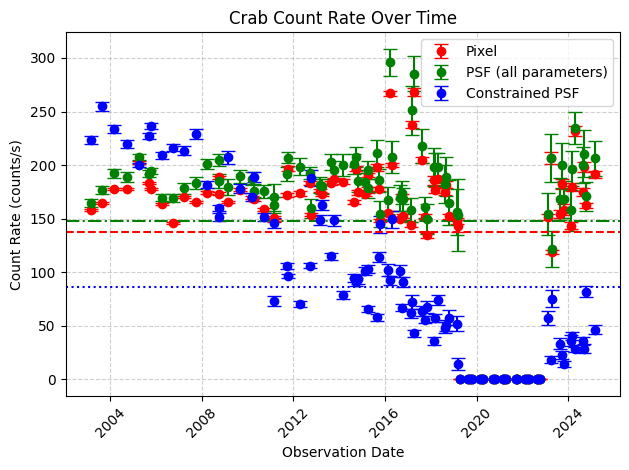

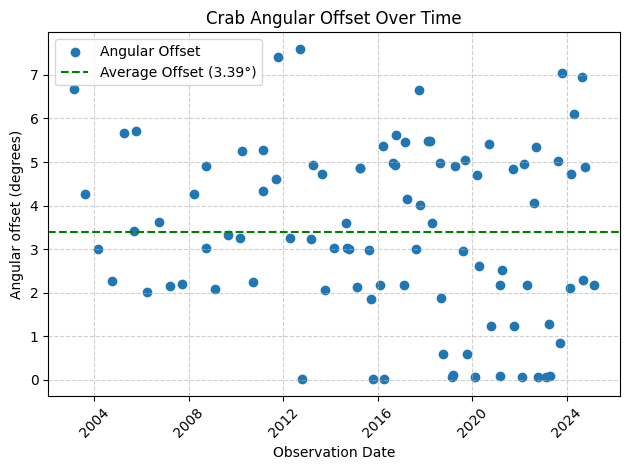

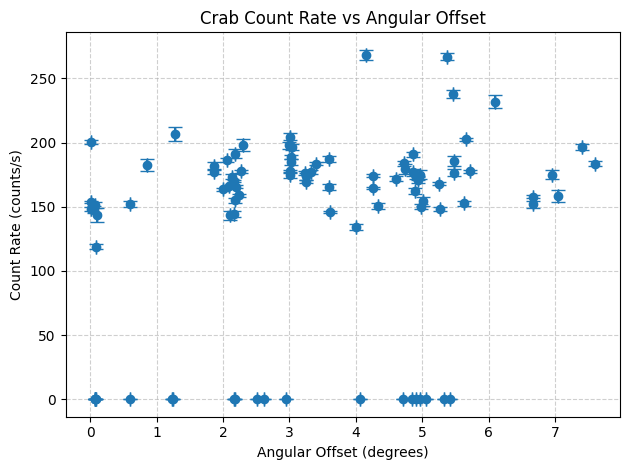

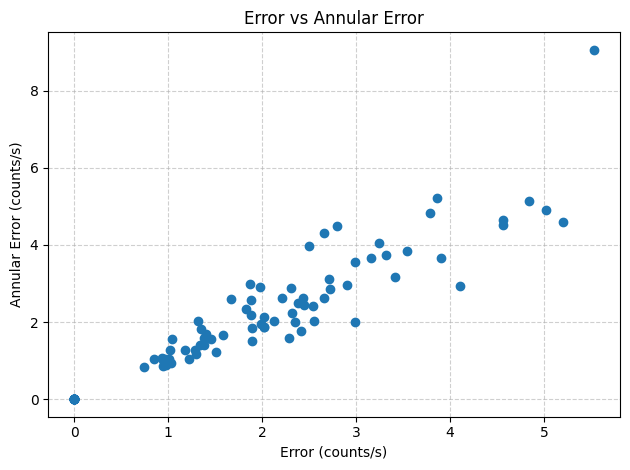

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

crab_countrates = np.array(crab_countrates)
crab_variances = np.array(crab_variances)
errors = np.sqrt(crab_variances)
offsets = np.array(offsets)
crab_annular_variances = np.array(crab_annular_variances)
annular_errors = np.sqrt(crab_annular_variances)
psf_counts = np.array(crab_psf_countrates)
psf_errors = np.array(crab_psf_errors)
fixed_psf_counts = np.array(crab_psf_countrates_fixed)
fixed_psf_errors = np.array(crab_psf_errors_fixed)

# Calculate average and standard deviation
avg_count_rate = np.mean(crab_countrates)
std_count_rate = np.std(crab_countrates)
avg_psfs = np.mean(psf_counts)
std_psfs = np.std(psf_counts)
avg_fixed_psfs = np.mean(fixed_psf_counts)
std_fixed_psfs = np.std(fixed_psf_counts)

avg_offset = np.mean(offsets)
std_offset = np.std(offsets)

# Plot count rate over time with errorbars and std region
plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, color='r', fmt='o', capsize=5, label='Pixel')
plt.errorbar(obs_times, psf_counts, yerr=psf_errors, color='g', fmt='o', capsize=5, label='PSF (all parameters)')
plt.errorbar(obs_times, fixed_psf_counts, yerr=fixed_psf_errors, color='b', fmt='o', capsize=5, label='Constrained PSF')
plt.axhline(avg_count_rate, color='r', linestyle='--')
plt.axhline(avg_psfs, color='g', linestyle='-.')
plt.axhline(avg_fixed_psfs, color='b', linestyle=':')
#plt.fill_between(obs_times, avg_count_rate - std_count_rate, avg_count_rate + std_count_rate, color='r', alpha=0.2, label=f'Standard Deviation ({std_count_rate:.2f})')
plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot angular offset from pointing center over time with std region
plt.figure()
plt.scatter(obs_times, offsets, label='Angular Offset')
plt.axhline(avg_offset, color='g', linestyle='--', label=f'Average Offset ({avg_offset:.2f}°)')
#plt.fill_between(obs_times, avg_offset - std_offset, avg_offset + std_offset, color='g', alpha=0.2, label=f'Standard Deviation ({std_offset:.2f}°)')
plt.xlabel("Observation Date")
plt.ylabel("Angular offset (degrees)")
plt.title("Crab Angular Offset Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot count rate vs angular offset
plt.figure()
plt.errorbar(offsets, crab_countrates, xerr=0, yerr=errors, fmt='o', capsize=5)
plt.xlabel("Angular Offset (degrees)")
plt.ylabel("Count Rate (counts/s)")
plt.title("Crab Count Rate vs Angular Offset")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Plot error vs annular error
plt.figure()
plt.errorbar(errors, annular_errors, fmt='o', capsize=5)
plt.xlabel("Error (counts/s)")
plt.ylabel("Annular Error (counts/s)")
plt.title("Error vs Annular Error")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()


## LIGHT CURVE

In [13]:
api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Crab"],
        [125.4826889038086],
        [crab_ra],
        [crab_dec],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

In [ ]:
'''lc_disp_by_date = {} 
lc_data_by_date = {}
successful_lc_scws = []

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

while True:
    lc_results = []

    for year_month in sorted(set(year_months)):
        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue
        
        # add filtering for not choosing the first 5 and last 10 ScWs of each revolution 
        # (ScWs look like RRRRPPPPSSS.001, so choose 5 < PPPP < max(PPPP) - 10)
        rrrr_max_pppp = defaultdict(int)
        for scwgr in filtered_scws:
            rrrr = scwgr[0][:4]  
            pppp = int(scwgr[0][4:8])
            rrrr_max_pppp[rrrr] = max(rrrr_max_pppp[rrrr], pppp)

        filtered_scws = [
            scwind for scwind in filtered_scws
            if 5 < int(scwind[0][4:8]) < rrrr_max_pppp[scwind[0][:4]] - 10
        ]

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering for pointings")
            continue
        else:
            print(f"{len(filtered_scws)} SCWs found for {year_month} after filtering for pointings")

        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration} for {year_month}")

            par_dict = {
                "RA": crab_ra,
                "DEC": crab_dec,
                "E1_keV": "15", 
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "time_bin": duration, 
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_lc",
                "product_type": "Real",
                "scw_list": [scw_id],
                #'token': disp.disable_email_token(oda_api.token.discover_token()),
                'selected_catalog': json.dumps(api_cat)
            }

            if scw_id not in lc_disp_by_date:
                lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = lc_disp_by_date[scw_id]

            data = lc_data_by_date.get(scw_id, None)

            if data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        data = _disp.get_product(**par_dict, silent=True)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        # continue  # Retry with the next SCW
                        # raise ValueError("Query incomplete")  # Force skipping the month
                        break

                    # Query successful, store the data
                    data = _disp.get_product(**par_dict, silent=True)
                    lc_data_by_date[scw_id] = data
                    lc_results.append(data)
                    successful_lc_scws.append(scw_id)
                    print(f"Query successful for SCW {scw_id}")
                    break  # Stop trying other SCWs for this month

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        else:
            print(f"All SCWs failed for {year_month}, skipping.")
            # print(f"Skipping {year_month} due to errors.")

    n_complete = len([year for year, _disp in lc_disp_by_date.items() if _disp.is_complete])
    print(f"complete {n_complete} / {len(lc_disp_by_date)}")

    if n_complete == len(lc_disp_by_date):
        print("done!")
        break
    print("not done")'''

In [16]:
lc_disp_by_date = {} 
lc_data_by_date = {}
successful_lc_scws = []

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

while True:
    lc_results = []

    for year_month in sorted(set(year_months)):

        filtered_scws = [
            (scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i])
            for i, year_month_in_list in enumerate(year_months)
            if year_month_in_list == year_month
        ]

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        # Add filtering for not choosing the first 5 and last 10 SCWs of each revolution
        rrrr_max_pppp = defaultdict(int)
        for scwgr in filtered_scws:
            rrrr = scwgr[0][:4]  
            pppp = int(scwgr[0][4:8])
            rrrr_max_pppp[rrrr] = max(rrrr_max_pppp[rrrr], pppp)

        filtered_scws = [
            scwind for scwind in filtered_scws
            if 5 < int(scwind[0][4:8]) < rrrr_max_pppp[scwind[0][:4]] - 10
        ]

        # Sort SCWs by duration (smallest first)
        filtered_scws.sort(key=lambda x: x[3]) 

        if not filtered_scws:
            print(f"No SCWs found for {year_month} after filtering for pointings")
            continue
        else:
            print(f"{len(filtered_scws)} SCWs found for {year_month} after filtering for pointings")
        

        # Process SCWs for the current year-month
        for scw_id, start_time, end_time, duration in filtered_scws:
            print(f"Trying SCW {scw_id} with duration {duration} for {year_month}")

            par_dict = {
                "RA": crab_ra,
                "DEC": crab_dec,
                "E1_keV": "15", 
                "E2_keV": "30",
                "T_format": "isot",
                'T1': start_time,
                'T2': end_time,
                "time_bin": duration, 
                "instrument": "isgri",
                "osa_version": "OSA11.2",
                "product": "isgri_lc",
                "product_type": "Real",
                "scw_list": [scw_id],
                #'token': disp.disable_email_token(oda_api.token.discover_token()),
                'selected_catalog': json.dumps(api_cat)
            }

            if scw_id not in lc_disp_by_date:
                lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)

            _disp = lc_disp_by_date[scw_id]

            lc_data = lc_data_by_date.get(scw_id, None)

            if lc_data is None and not _disp.is_failed:
                try:
                    if not _disp.is_submitted:
                        lc_data = _disp.get_product(**par_dict, silent=True)
                    else:
                        _disp.poll()

                    if not _disp.is_complete:
                        break  # Continue to the next SCW if not complete

                    lc_data = _disp.get_product(**par_dict, silent=True)
                    lc_data_by_date[scw_id] = lc_data
                    lc_results.append(lc_data)
                    successful_lc_scws.append(scw_id)
                    print(f"Query successful for SCW {scw_id}")
                    break  # Stop trying other SCWs for this month if one is successful

                except Exception as e:
                    print(f"Query failed for SCW {scw_id}: {e}")
                    continue  # Try the next SCW

        print(f"Finished processing {year_month}. Moving to the next month.")

    # Now, poll all SCWs that have been submitted
    print("Polling for completion of all SCWs.")
    n_complete = 0

    # Poll all SCWs that have been submitted (skip already completed ones)
    for scw_id, _disp in lc_disp_by_date.items():
        if _disp.is_complete and scw_id not in lc_data_by_date:
            try:
                lc_data = _disp.get_product(silent=True)
                lc_data_by_date[scw_id] = lc_data
                lc_results.append(lc_data)
                successful_lc_scws.append(scw_id)
                print(f"Data retrieved for SCW {scw_id}")
            except Exception as e:
                print(f"Error retrieving data for SCW {scw_id}: {e}")

        if _disp.is_complete:
            n_complete += 1

    print(f"Complete {n_complete} / {len(disp_by_date)}")

    if n_complete == len(lc_disp_by_date):
        print("All SCWs complete! Done.")
        break
    print("Not done, waiting for SCWs to finish...")


172 SCWs found for 2003-02 after filtering for pointings
Trying SCW 004500180010.001 with duration 2162.001118948683 for 2003-02
Query successful for SCW 004500180010.001
Finished processing 2003-02. Moving to the next month.
No SCWs found for 2003-03 after filtering for pointings
No SCWs found for 2003-04 after filtering for pointings
19 SCWs found for 2003-08 after filtering for pointings
Trying SCW 010200140010.001 with duration 2199.001089250669 for 2003-08
Query successful for SCW 010200140010.001
Finished processing 2003-08. Moving to the next month.
25 SCWs found for 2004-03 after filtering for pointings
Trying SCW 017000770010.001 with duration 1799.0010403795168 for 2004-03
Query successful for SCW 017000770010.001
Finished processing 2004-03. Moving to the next month.
No SCWs found for 2004-04 after filtering for pointings
No SCWs found for 2004-08 after filtering for pointings
79 SCWs found for 2004-09 after filtering for pointings
Trying SCW 023900810010.001 with duration 1

Save FITS

In [29]:
# Save FITS files
for i, data in enumerate(lc_results):
    lc = OdaLightCurve(data)
    lc.write_fits("Crab")
    new_filename = f"../data/CrabLC_FITS_15_30/{successful_lc_scws[i]}"
    os.rename("IBIS_lc_Crab.fits", new_filename)

Light curve analysis

In [33]:
from datetime import datetime

crab_lc_countrates = []
crab_lc_errors = []
lc_start_dates = []
lc_end_dates = []

for result in lc_results:

    lc = result._p_list[0]

    start_time = lc.data_unit[1].header['TSTART']
    end_time = lc.data_unit[1].header['TSTOP']
    mjd_ref = lc.data_unit[1].header['MJDREF'] 
    start_date = Time(mjd_ref + start_time, format='mjd').isot
    end_date = Time(mjd_ref + end_time, format='mjd').isot

    rate = lc.data_unit[1].data['RATE']
    error = lc.data_unit[1].data['ERROR']

    crab_lc_countrates.append(rate)
    crab_lc_errors.append(error)
    lc_start_dates.append(start_date)
    lc_end_dates.append(end_date)

Save data to file

In [34]:
E1, E2 = 15, 30
output_lc_file = f"../data/crab_longterm_lc_data_{E1}_{E2}.txt"

lc_data = np.column_stack([np.sort(successful_lc_scws), lc_start_dates, lc_end_dates, crab_lc_countrates, crab_lc_errors])

lc_header = "SCW, Obs Start Date, Obs End Date, Count Rate, Error"

np.savetxt(output_lc_file, lc_data, fmt="%s", delimiter=",", header=lc_header, comments="")

print(f"Data saved to {output_lc_file}")

Data saved to ../data/crab_longterm_lc_data_15_30.txt


Plot

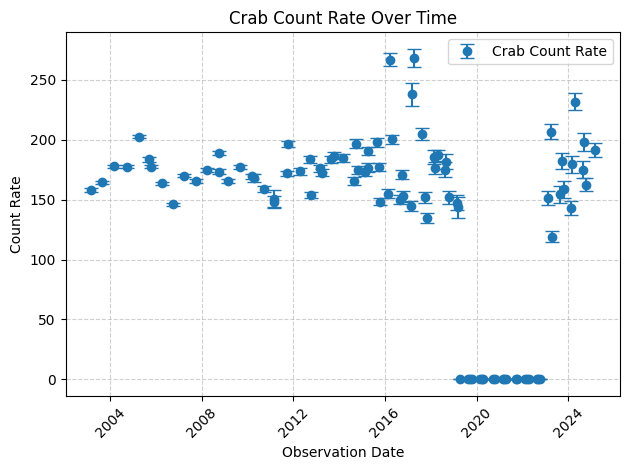

In [45]:
from datetime import datetime

lc_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f") for date in lc_start_dates]

lc_rates = np.array(crab_countrates)
lc_err = np.array(crab_lc_errors).flatten()

plt.figure()
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Crab Count Rate")
plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## COMPARISON
Here we compare the count rate of the Crab over time between the two methods (using images or light curves)

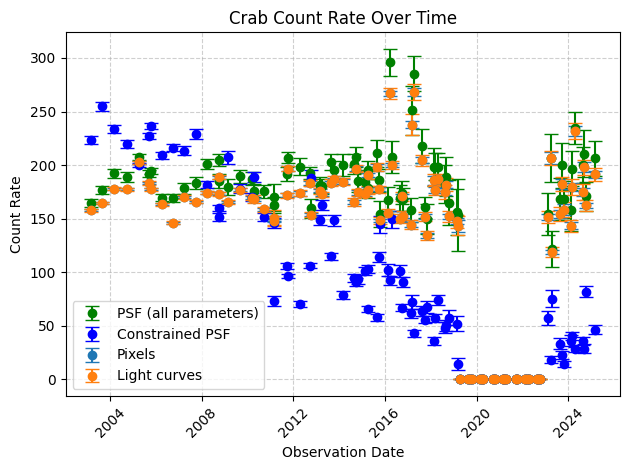

In [47]:
plt.figure()

plt.errorbar(obs_times, psf_counts, yerr=psf_errors, color='g', fmt='o', capsize=5, label='PSF (all parameters)')
plt.errorbar(obs_times, fixed_psf_counts, yerr=fixed_psf_errors, color='b', fmt='o', capsize=5, label='Constrained PSF')
plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Pixels")
plt.errorbar(lc_times, lc_rates, yerr=lc_err, fmt='o', capsize=5, label="Light curves")

plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()